* Autor Danilo Fornari - dfornari@icloud.com

# Previsão de Renda

Desenvolver e aplicar os modelos de classificação e ML para prever a possibilidade de um indivíduo ganhar mais de 50K dentro das variáveis com maior significância estatística 

## Importando Bibliotecas

In [112]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
sns.set(style="white")
import seaborn as sns
from scipy.stats import chi2_contingency
import os
#Configurando parametros de exibicao do pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## Importando Base de Dados

In [67]:
#importanto conteudo do CSV para um DataFrame
adultdf = pd.read_csv("adult.csv")
adultdf

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country,class
0,2,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,1,0,2,United-States,<=50K
1,3,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,0,United-States,<=50K
2,2,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,2,United-States,<=50K
3,3,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,2,United-States,<=50K
4,1,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,2,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,2,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,2,United-States,<=50K
48838,4,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,2,United-States,<=50K
48839,2,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,3,United-States,<=50K
48840,2,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,2,0,2,United-States,<=50K


## Análisando o DataFrame superficialmente

In [68]:
#Verificando o shape
adultdf.shape


(48842, 15)

In [69]:
#Verificado a classificação das variáveis
adultdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
age               48842 non-null int64
workclass         46043 non-null object
fnlwgt            48842 non-null int64
education         48842 non-null object
education-num     48842 non-null int64
marital-status    48842 non-null object
occupation        46033 non-null object
relationship      48842 non-null object
race              48842 non-null object
sex               48842 non-null object
capitalgain       48842 non-null int64
capitalloss       48842 non-null int64
hoursperweek      48842 non-null int64
native-country    47985 non-null object
class             48842 non-null object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


* A Classificação das variáveis por tipo parece correta

In [70]:
#Verificando Nulls
miss_sum = pd.DataFrame(adultdf.isnull().sum().sort_values(ascending=False), columns = ['Total'])
miss_percent = pd.DataFrame((adultdf.isnull().sum()/adultdf.isnull().count()*100), columns = ['Percentage'])
missfulldf = pd.concat([miss_sum,miss_percent], axis=1)
print(missfulldf[missfulldf['Total']>0])
print('\n********TOTALS**********\n',missfulldf[missfulldf['Total']>0].count())

                Total  Percentage
native-country    857    1.754637
occupation       2809    5.751198
workclass        2799    5.730724

********TOTALS**********
 Total         3
Percentage    3
dtype: int64


/Library/Python/3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


* Existem 3 variáveis com valores missing, precisarão ser preenchidos ou excluidos

In [71]:
#Verificando Variaveis com valor = 0
zeros_sum = pd.DataFrame(adultdf[(adultdf==0)].count().sort_values(ascending=False), columns = ['Total'])
zeros_percent = pd.DataFrame((adultdf[(adultdf==0)].count()/adultdf.isnull().count()*100), columns = ['Percentage'])
zerosfulldf = pd.concat([zeros_sum,zeros_percent], axis=1)
print(zerosfulldf[zerosfulldf['Total']>0])
print('\n********TOTALS**********\n',zerosfulldf[zerosfulldf['Total']>0].count())

              Total  Percentage
age            9627   19.710495
capitalgain   44807   91.738668
capitalloss   46560   95.327792
hoursperweek   4453    9.117153

********TOTALS**********
 Total         4
Percentage    4
dtype: int64


/Library/Python/3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


* As variáveis Horasporsemana, Ganho, Perda e Idade tem valores igual a zero, mas isso é aceitável dentro da proposta da variável
* As variáveis Ganho e Perda tem mais de 90% de zero, mesmo que essa entrada não esteja errada o fato de uma variável ter 90% do valor igual mostra que ela será muito pouco representativa para prever o nosso target.

In [72]:
#Convertendo variáveis categóricas
adultdf = adultdf.astype({"workclass":"category","education":"category","marital-status":"category",\
                         "occupation":"category","relationship":"category","race":"category","sex":"category",\
                         "class":"category","native-country":"category"})
adultdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
age               48842 non-null int64
workclass         46043 non-null category
fnlwgt            48842 non-null int64
education         48842 non-null category
education-num     48842 non-null int64
marital-status    48842 non-null category
occupation        46033 non-null category
relationship      48842 non-null category
race              48842 non-null category
sex               48842 non-null category
capitalgain       48842 non-null int64
capitalloss       48842 non-null int64
hoursperweek      48842 non-null int64
native-country    47985 non-null category
class             48842 non-null category
dtypes: category(9), int64(6)
memory usage: 2.7 MB


In [73]:
#Verificando dados estatísticos das variáveis quantitativas
adultdf.describe().T

,count,mean,std,min,25%,50%,75%,max
age,48842.0,1.771078,1.295378,0.0,1.0,2.0,3.0,4.0
fnlwgt,48842.0,189664.134597,105604.025423,12285.0,117550.5,178144.5,237642.0,1490400.0
education-num,48842.0,10.078089,2.570973,1.0,9.0,10.0,12.0,16.0
capitalgain,48842.0,0.200319,0.746182,0.0,0.0,0.0,0.0,4.0
capitalloss,48842.0,0.114942,0.556924,0.0,0.0,0.0,0.0,4.0
hoursperweek,48842.0,1.950698,0.897038,0.0,2.0,2.0,2.0,4.0


* Será necessário padronizar a variável fnlwgt
* Variáveis capitalgain, capitalloss, hoursperweek apresentam mais de 75% de dados igual logo contribuem muito pouco para nosso modelo preditivo

In [18]:
#Verificando dados estatísticos das variáveis qualitativas
df_des = adultdf.describe(include="category").T.sort_values(by='freq', ascending=False)
df_des["Freq%"]= df_des["freq"]/df_des["count"]
df_des

,count,unique,top,freq,Freq%
native-country,47985,41,United-States,43832,0.913452
race,48842,5,White,41762,0.855043
class,48842,2,<=50K,37155,0.760718
workclass,46043,8,Private,33906,0.736399
sex,48842,2,Male,32650,0.668482
marital-status,48842,7,Married-civ-spouse,22379,0.458192
relationship,48842,6,Husband,19716,0.403669
education,48842,16,HS-grad,15784,0.323164
occupation,46033,14,Prof-specialty,6172,0.134078


* **A Variável target não esta distribuida de forma igualitária, 76% dos resultados são <=50, isso explica por que tantas variáveis tem um freq >= 75%**
* Native-Country tem mais de 90% de valores repetidos, mais uma variável dispensável para o modelo

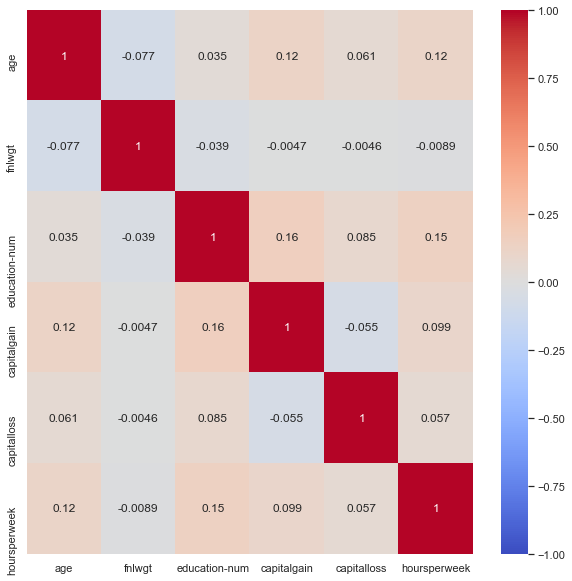

In [19]:
#Verificanndo a correlação entre as variáveis numéricas
plt.figure(figsize=(10,10))
sns.heatmap(adultdf.corr(),
            vmin=-1,
            cmap='coolwarm',
            annot=True);

* Não existe colinearidade entre as variáveis quantitativas

In [25]:
#Verificando a distribuição dos grupos
column = adultdf.columns
for i in column:
    print('***** ',i, '******\n')
    print(adultdf[i].value_counts(),'\n')
    print(adultdf[i].value_counts()/adultdf[i].count(),'\n')
    

*****  age ******

1    12719
2    11952
0     9627
3     8296
4     6248
Name: age, dtype: int64 

1    0.260411
2    0.244707
0    0.197105
3    0.169854
4    0.127923
Name: age, dtype: float64 

*****  workclass ******

Private             33906
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64 

Private             0.736399
Self-emp-not-inc    0.083878
Local-gov           0.068110
State-gov           0.043025
Self-emp-inc        0.036813
Federal-gov         0.031101
Without-pay         0.000456
Never-worked        0.000217
Name: workclass, dtype: float64 

*****  fnlwgt ******

203488    21
120277    19
190290    19
125892    18
126569    18
          ..
170272     1
137444     1
172327     1
111368     1
208174     1
Name: fnlwgt, Length: 28523, dtype: int64 

203488    0.000430
120277    0.000389
190290    0.000389
12589

## Análise de variáveis

In [26]:
#Separando variáveis por tipo para facilitar a análise
featdf = pd.DataFrame(adultdf.dtypes,columns=['Data_Type'])
print('****************************************************************************************************')
print('Category Variables')
print('****************************************************************************************************\n')
print(featdf[featdf['Data_Type']=='category'])
print('\n**Total: ',featdf[featdf['Data_Type']=='category'].count(),'**')
print('\n ****************************************************************************************************')
print('Numerical Variables')
print('****************************************************************************************************\n')
print(featdf[featdf['Data_Type']!='category'])
print('\n**Total: ',featdf[featdf['Data_Type']!='category'].count(),'**')

****************************************************************************************************
Category Variables
****************************************************************************************************

               Data_Type
workclass       category
education       category
marital-status  category
occupation      category
relationship    category
race            category
sex             category
native-country  category
class           category

**Total:  Data_Type    9
dtype: int64 **

 ****************************************************************************************************
Numerical Variables
****************************************************************************************************

              Data_Type
age               int64
fnlwgt            int64
education-num     int64
capitalgain       int64
capitalloss       int64
hoursperweek      int64

**Total:  Data_Type    6
dtype: int64 **


In [79]:
#Gerando listas com variáveis numericas e categóricas
nunfeat = list(featdf[featdf['Data_Type']!='category'].index)
catfeat = list(featdf[featdf['Data_Type']=='category'].index)

## Analisando variáveis quantitativas

/Library/Python/3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Library/Python/3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Library/Python/3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Library/Python/3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprec

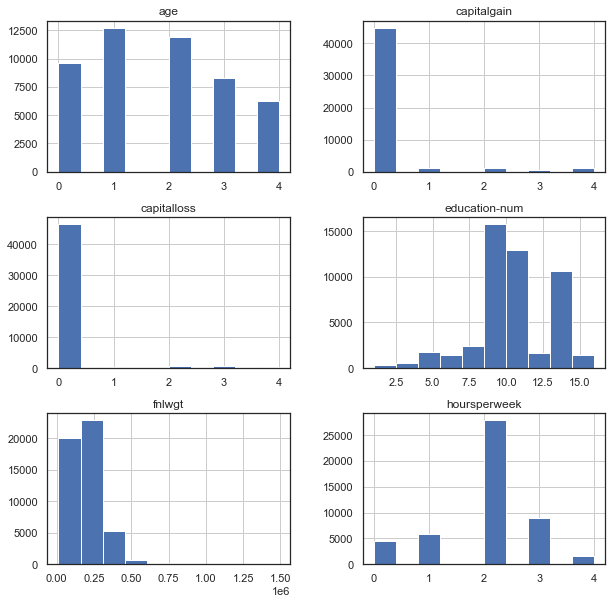

In [30]:
#Histograma
adultdf.hist(figsize=(10,10))
plt.show()

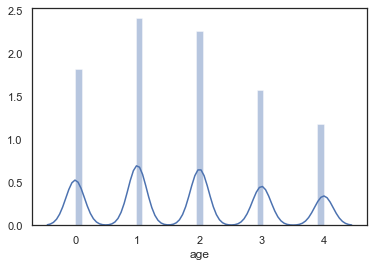

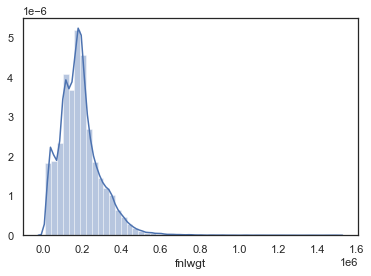

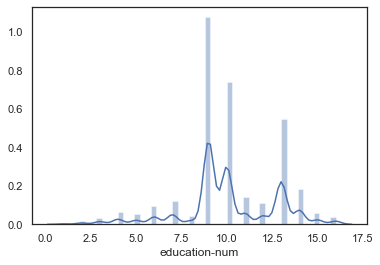

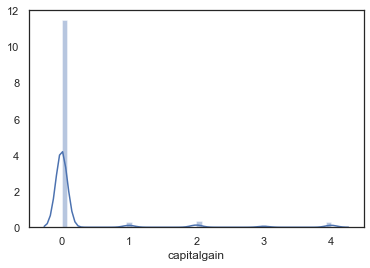

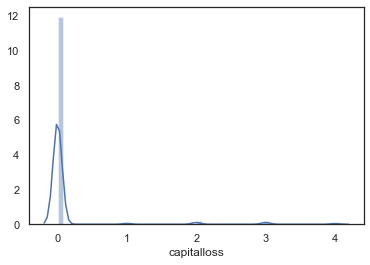

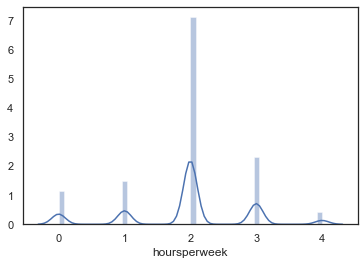

In [32]:
#Gráficos de distribuição
for i in nunfeat:
    sns.distplot(adultdf[i])
    plt.show()

* Variável fnlwgt é assimétrica a Direita

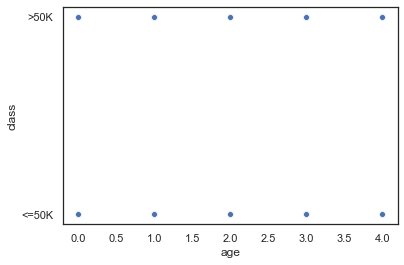

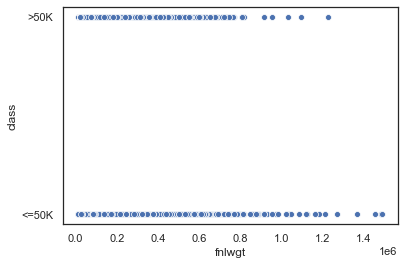

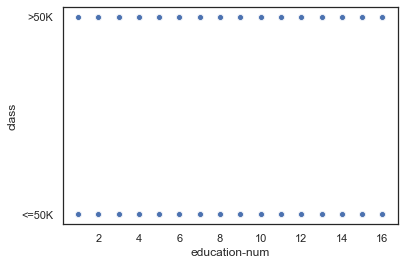

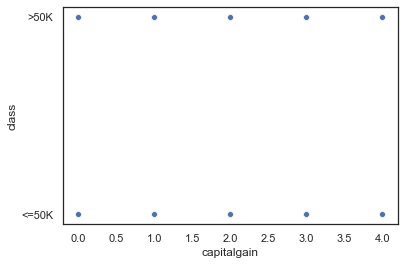

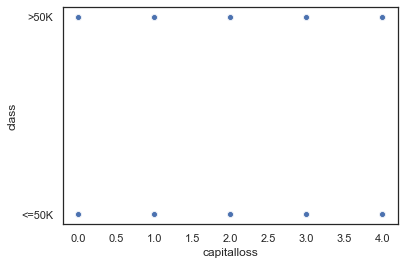

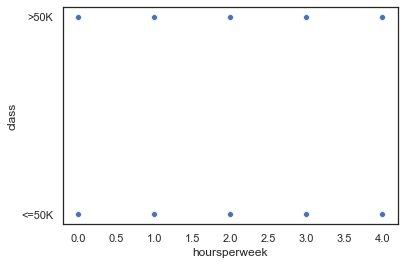

In [40]:
#Grafico de disperção(neste caso como o taget é categórica não fica muito claro)
for graf in nunfeat:
    sns.scatterplot(x=graf, y='class', data=adultdf)
    plt.show()

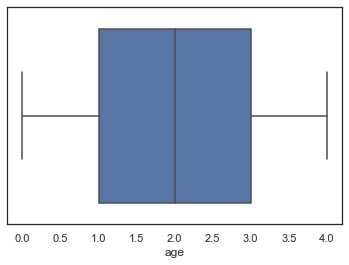

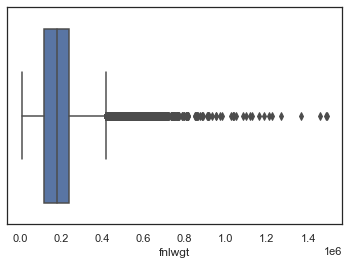

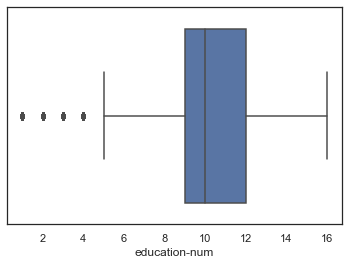

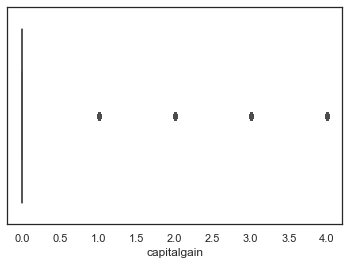

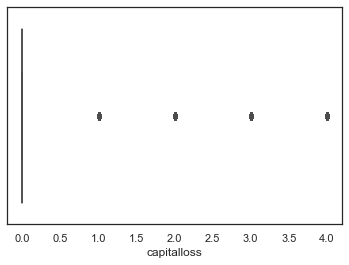

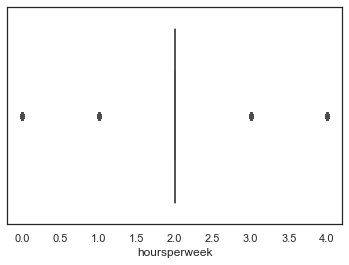

In [41]:
#Grafico boxplot
for graf2 in nunfeat:
    sns.boxplot(adultdf[graf2])
    plt.show()

* Com exceção da variável Age, todas as demais tem outliers

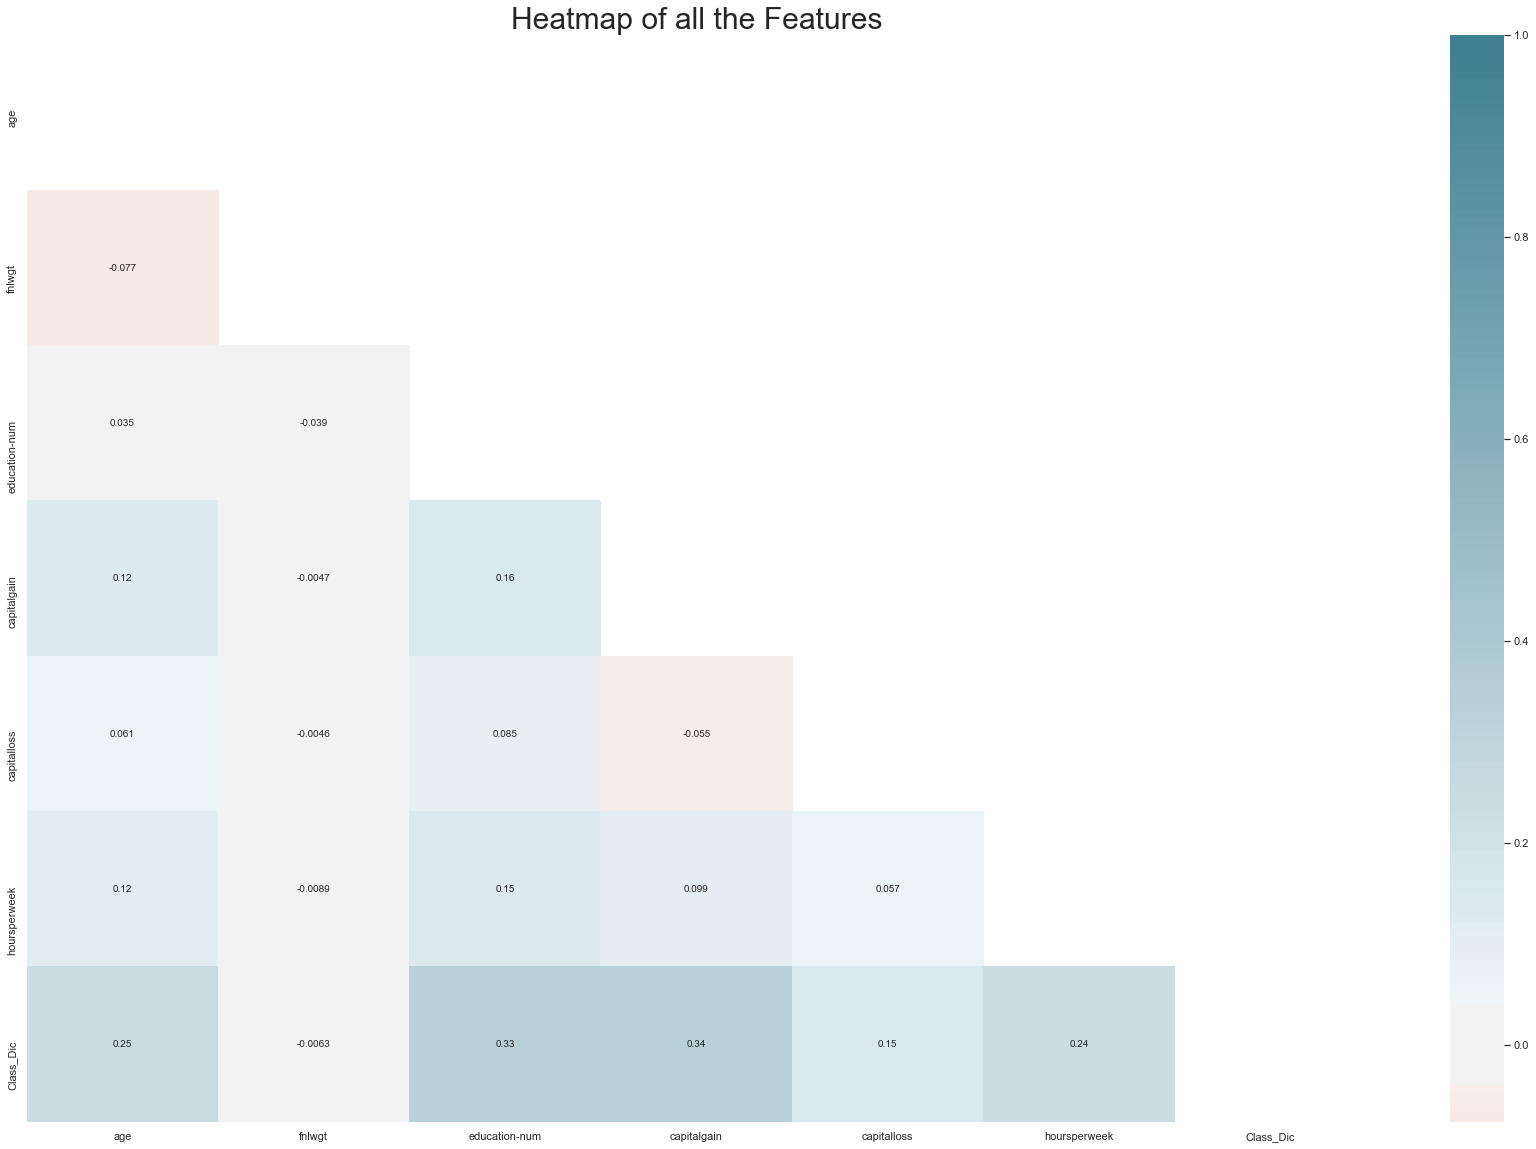

In [74]:
#Verificando novamente correlações das variáveis numéricas
#Criando um novo DF com a variável class dicotômica
adultdf2 = adultdf.copy()
adultdf2['Class_Dic']= adultdf2['class'].apply(lambda v : 1 if v=='>50K' else 0)
adultdf2['Class_Dic']=adultdf2['Class_Dic'].astype(int)
import matplotlib.style as style
style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (30,20))
 
mask = np.zeros_like(adultdf2.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(adultdf2.corr(), cmap=sns.diverging_palette(20, 220, n=200), mask = mask, annot=True, center = 0, );
plt.title("Heatmap of all the Features", fontsize = 30);

In [75]:
#Verificando a correlação pelo teste do Chi_Quadrado
from scipy.stats import chi2_contingency

#criando função para testar as variáveis de forma cruzada
def chisq_func(df, c1, c2):
    groupsizes = df.groupby([c1, c2]).size()
    ctsum = groupsizes.unstack(c1)
    return(chi2_contingency(ctsum.fillna(0)))

print('************Chi_Quadrado*****************\n')
pvalues = []
for feat in nunfeat:
    print(feat)
    chires = chisq_func(adultdf,feat,'class')
    print(chires[1])
    pvalues.append(chires[1])
chidf = pd.DataFrame(pvalues,index=[nunfeat],columns=['P-Value'])
chidf.sort_values(by='P-Value')

************Chi_Quadrado*****************

age
0.0
fnlwgt
1.1990637490372914e-18
education-num
0.0
capitalgain
0.0
capitalloss
9.14762633810934e-277
hoursperweek
0.0


,P-Value
age,0.000000e+00
education-num,0.000000e+00
capitalgain,0.000000e+00
hoursperweek,0.000000e+00
capitalloss,9.147626e-277
fnlwgt,1.199064e-18


* Todas as variáveis numéricas descrevem estatiscamente a variável target pois em todas o P-Valor é inferior a 5%

## Analisando Variáveis Qualitativas

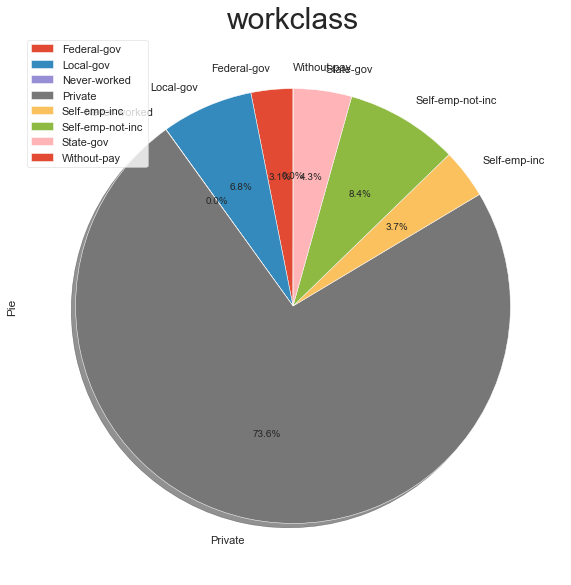

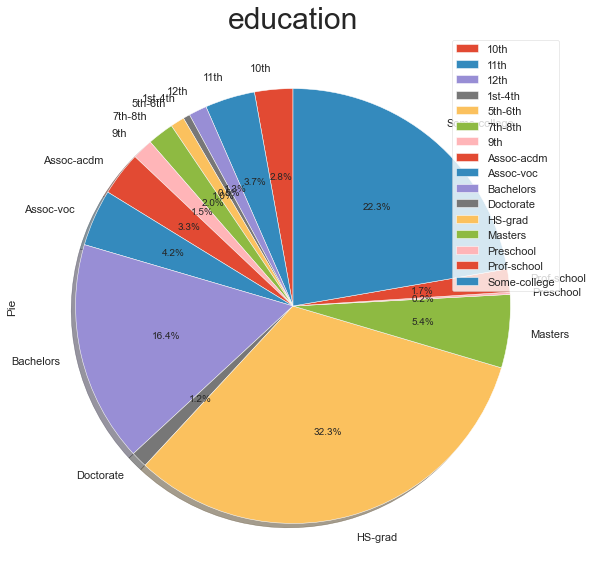

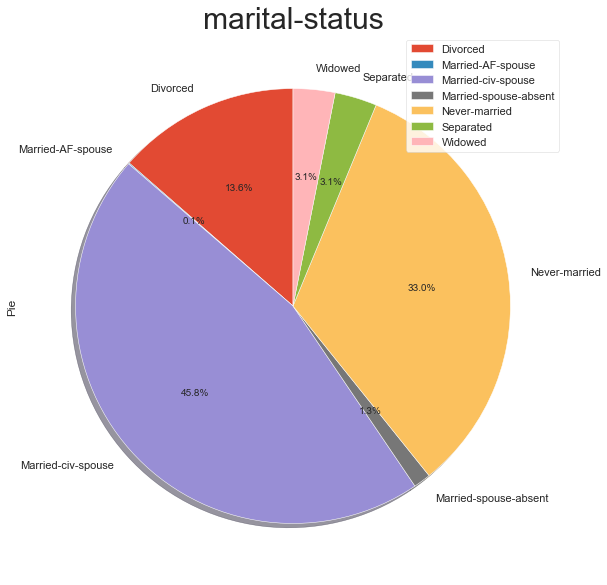

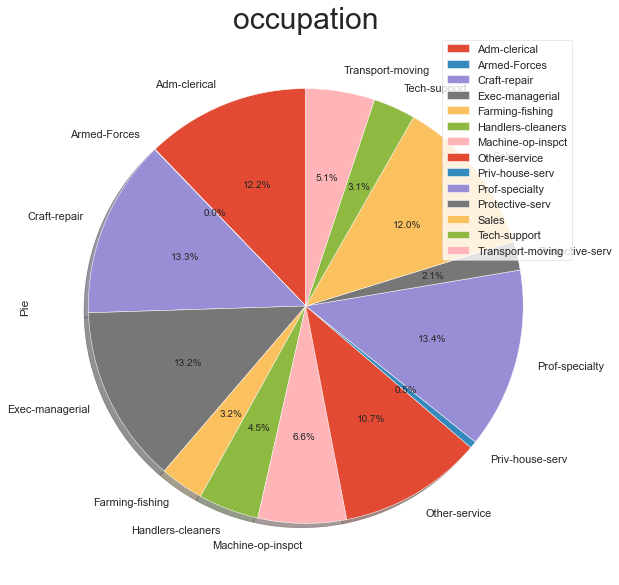

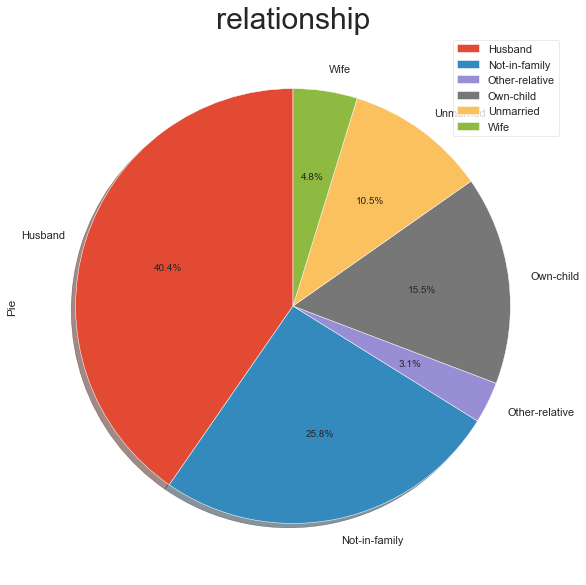

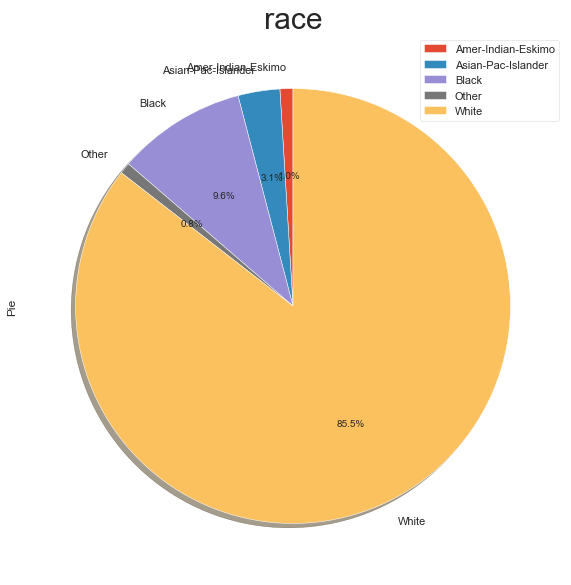

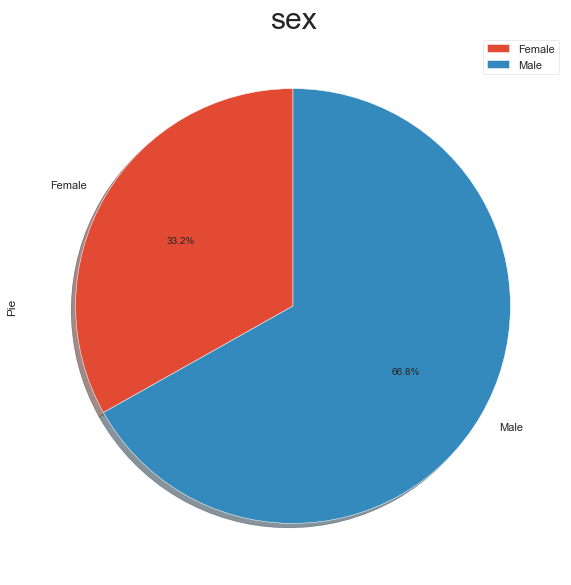

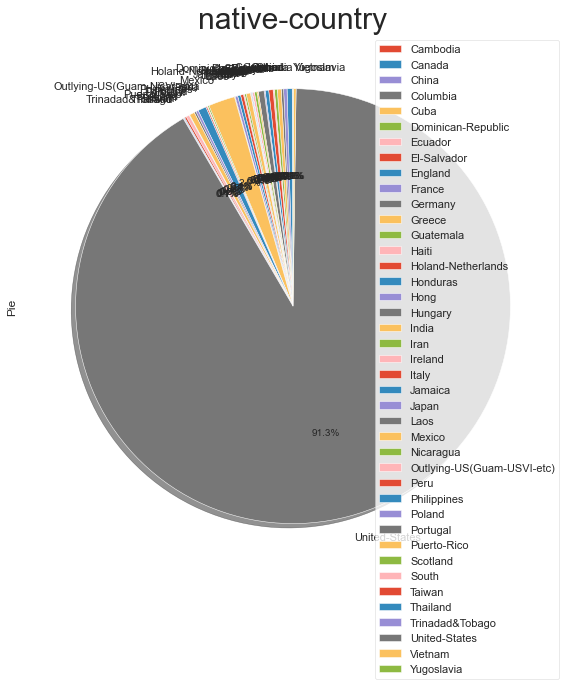

In [76]:
#Gráfico de pizza para verificar a distribuição da variável
dfpie = adultdf.copy()
#Criando coluna com numeros 1 para fazer as somas
dfpie['Pie']= 1
for pie in catfeat:
    dfpie.groupby([pie]).sum().plot(kind='pie', y='Pie', shadow = True,startangle=90,\
                                         figsize=(10,10), autopct='%1.1f%%')
    plt.title(pie, fontsize=30)
    plt.show()

* A Maioria das pessoas do DF trabalham na iniciativa privada
* Os três maiores grupos do DF estão respectivamente no High School, 7/8 ano ou Bacharelado
* A Maioria das pessoas do DF é casado ou solteiro
* Forças armadas e serviços domiciliares são menores grupos neste DF
* A Maioria das pessoas do DF é marido ou não têm familia, a minoria são de esposas
* A Maioria das pessoas do DF é da raça branca
* A Maioria das pessoas do DF são homens
* A Maioria das pessoas do DF são dos EUA
* A Maioria das pessoas do DF ganha menos de 50k

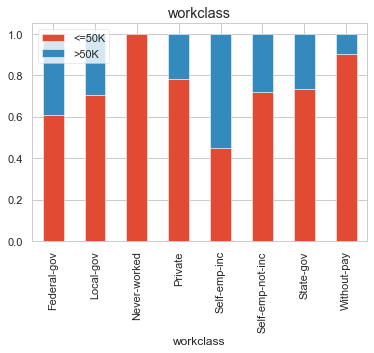

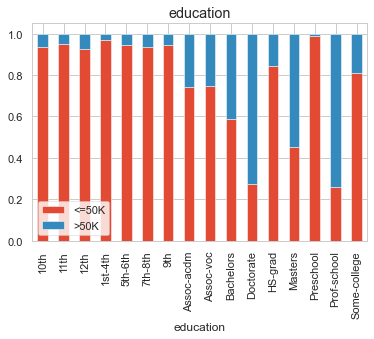

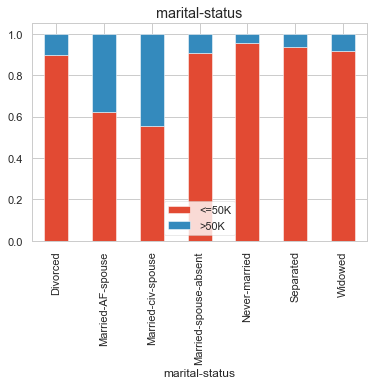

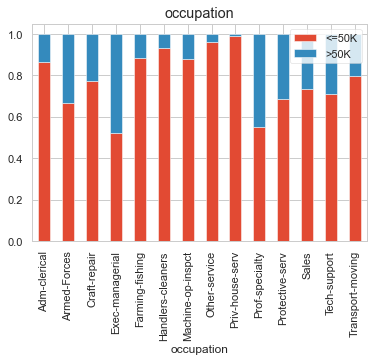

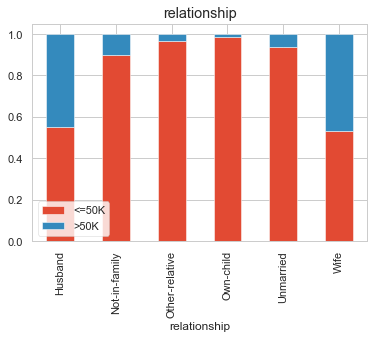

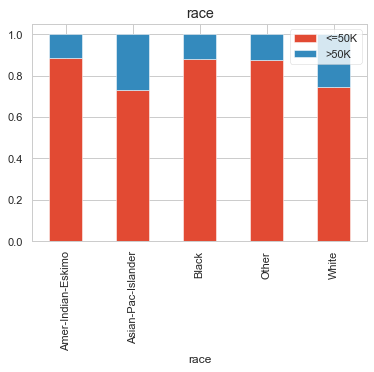

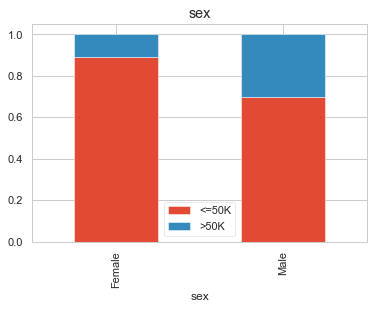

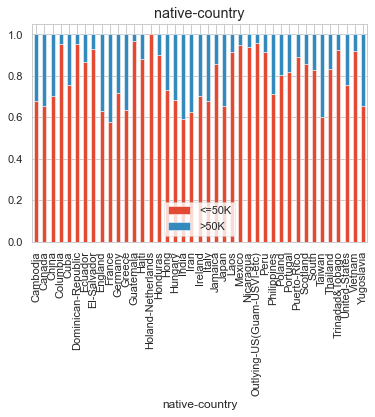

In [77]:
#Gráfico de barras emplilhado para verificar distribuição e correlação com o target
for stk in catfeat:
    if stk == 'class':
        pass
    else:
        #Criando uma tabela cruzada com as duas variáveis e usando apply para tranformar em % do total
        dfc= pd.crosstab(adultdf[stk],adultdf['class']).apply(lambda r: r/r.sum(), axis = 1)
        #Criando o gráfico bar stacked
        ax1 = dfc.plot(kind = "bar", stacked = True, title = stk)
        lines, labels = ax1.get_legend_handles_labels()
        ax1.legend(lines,["<=50K", ">50K"], loc = 'best')

* A Chances de ganhar mais de 50k são maiores quando você têm sua própria empresa ou trabalha para o Governo, e mínimas se a pessoa nunca trabalhou.
* As Maiores rendas estão concentradas em pessoas com doutorado ou Prof-school
* As Maiores rendas estão concentradas em pessoas casadas
* As Maiores rendas estão concentradas nos cargos de gerentes-executivo e Especialistas
* As Maiores rendas estão concentradas em pessoas casadas sem filhos
* As Maiores rendas estão concentradas em pessoas do sexo masculino


In [80]:
#Verificando a correlação pelo teste do Chi_Quadrado
from scipy.stats import chi2_contingency

#criando função para testar as variáveis de forma cruzada
def chisq_func(df, c1, c2):
    groupsizes = df.groupby([c1, c2]).size()
    ctsum = groupsizes.unstack(c1)
    return(chi2_contingency(ctsum.fillna(0)))

print('************Chi_Quadrado*****************\n')
pvalues = []
for feat in catfeat:
    if feat == 'class':
        pass
    else:
        print(feat)
        chires = chisq_func(adultdf,feat,'class')
        print(chires[1])
        pvalues.append(chires[1])
catfeat2 = catfeat
catfeat2.remove('class')
chidf = pd.DataFrame(pvalues,index=[catfeat2],columns=['P-Value'])
chidf.sort_values(by='P-Value')

************Chi_Quadrado*****************

workclass
2.6121798441465798e-263
education
0.0
marital-status
0.0
occupation
0.0
relationship
0.0
race
4.2843777102233777e-104
sex
0.0
native-country
4.9465504983432925e-71


,P-Value
education,0.000000e+00
marital-status,0.000000e+00
occupation,0.000000e+00
relationship,0.000000e+00
sex,0.000000e+00
workclass,2.612180e-263
race,4.284378e-104
native-country,4.946550e-71


* Todas as variáveis categóricas descrevem estatiscamente a variável target pois em todas o P-Valor é inferior a 5%

# Engenharia de Dados

## Preechendo valores Missing


* native-country -- Dropar, 90% Valores repetidos
* occupation -- Preencher
* workclass -- Preencher



## Occupation

In [83]:
#Verificando valores NaN
adultdf2[adultdf2['occupation'].isnull()]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country,class,Class_Dic
27,3,NaN,180211,Some-college,10,Married-civ-spouse,NaN,Husband,Asian-Pac-Islander,Male,0,0,3,South,>50K,1
61,1,NaN,293936,7th-8th,4,Married-spouse-absent,NaN,Not-in-family,White,Male,0,0,2,NaN,<=50K,0
69,0,NaN,200681,Some-college,10,Never-married,NaN,Own-child,White,Male,0,0,2,United-States,<=50K,0
77,4,NaN,212759,10th,6,Married-civ-spouse,NaN,Husband,White,Male,0,0,0,United-States,<=50K,0
106,0,NaN,304873,10th,6,Never-married,NaN,Own-child,White,Female,4,0,1,United-States,<=50K,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48682,4,NaN,265201,Some-college,10,Married-civ-spouse,NaN,Husband,White,Male,0,0,0,United-States,<=50K,0
48769,0,NaN,212661,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,1,United-States,<=50K,0
48800,4,NaN,144872,HS-grad,9,Married-civ-spouse,NaN,Husband,White,Male,0,0,1,Canada,<=50K,0
48812,4,NaN,26711,Assoc-voc,11,Married-civ-spouse,NaN,Husband,White,Male,1,0,0,United-States,<=50K,0


In [86]:
#Verificando quatidade de categorias possiveis para avalidar alternativas de preenchimento
adultdf2['occupation'].cat.categories

Index(['Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial',
       'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct',
       'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv',
       'Sales', 'Tech-support', 'Transport-moving'],
      dtype='object')

In [107]:
#Verificando a correlação pelo de Occupation com as outras Variaveis teste do Chi_Quadrado
from scipy.stats import chi2_contingency

#Criando um DF sem Occupation NaN
adultdf3 = adultdf2.copy()
adultdf3['occupation'] = adultdf3['occupation'].dropna()

#Criando lista de variaveis
rem = ['occupation','Class_Dic','class']
listachi = [elem for elem in list(adultdf2.columns) if elem not in rem]

#criando função para testar as variáveis de forma cruzada
def chisq_func(df, c1, c2):
    groupsizes = df.groupby([c1, c2]).size()
    ctsum = groupsizes.unstack(c1)
    return(chi2_contingency(ctsum.fillna(0)))

print('************Chi_Quadrado*****************\n')
pvalues = []
for feat in listachi:
    print(feat)
    chires = chisq_func(adultdf3,feat,'class')
    print(chires[1])
    pvalues.append(chires[1])
chidf = pd.DataFrame(pvalues,index=[listachi],columns=['P-Value'])
chidf.sort_values(by='P-Value')

************Chi_Quadrado*****************

age
0.0
workclass
2.6121798441465798e-263
fnlwgt
1.1990637490372914e-18
education
0.0
education-num
0.0
marital-status
0.0
relationship
0.0
race
4.2843777102233777e-104
sex
0.0
capitalgain
0.0
capitalloss
9.14762633810934e-277
hoursperweek
0.0
native-country
4.9465504983432925e-71


,P-Value
age,0.000000e+00
education,0.000000e+00
education-num,0.000000e+00
marital-status,0.000000e+00
relationship,0.000000e+00
sex,0.000000e+00
capitalgain,0.000000e+00
hoursperweek,0.000000e+00
capitalloss,9.147626e-277
workclass,2.612180e-263


* Occupation e Workclass tem uma forte correlação, logo é possivel que eles tenham os mesmos valores NaN

In [115]:
#Verificando linhas onde ambos Occupationn e Workclass são NaN
adultdf2[(adultdf2['occupation'].isnull())&(adultdf2['workclass'].isnull())]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country,class,Class_Dic
27,3,NaN,180211,Some-college,10,Married-civ-spouse,NaN,Husband,Asian-Pac-Islander,Male,0,0,3,South,>50K,1
61,1,NaN,293936,7th-8th,4,Married-spouse-absent,NaN,Not-in-family,White,Male,0,0,2,NaN,<=50K,0
69,0,NaN,200681,Some-college,10,Never-married,NaN,Own-child,White,Male,0,0,2,United-States,<=50K,0
77,4,NaN,212759,10th,6,Married-civ-spouse,NaN,Husband,White,Male,0,0,0,United-States,<=50K,0
106,0,NaN,304873,10th,6,Never-married,NaN,Own-child,White,Female,4,0,1,United-States,<=50K,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48682,4,NaN,265201,Some-college,10,Married-civ-spouse,NaN,Husband,White,Male,0,0,0,United-States,<=50K,0
48769,0,NaN,212661,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,1,United-States,<=50K,0
48800,4,NaN,144872,HS-grad,9,Married-civ-spouse,NaN,Husband,White,Male,0,0,1,Canada,<=50K,0
48812,4,NaN,26711,Assoc-voc,11,Married-civ-spouse,NaN,Husband,White,Male,1,0,0,United-States,<=50K,0


* São exatamente as mesmas linhas, logo se droparmos os valores NaN de occupation vamos também eliminar os nulos de workclass

In [131]:
#Dropando os valores nulos de occupation
adultdf4 = adultdf2.copy()
adultdf4.dropna(subset=['occupation'],inplace=True)

In [134]:
#Verificando DF após exclusão
print('Shape do DF antes da exclusão: ', adultdf2.shape)
print('\nShape do DF apos da exclusão: ', adultdf4.shape)

print('\nValores NaN no novo DF')
#Verificando Nulls
miss_sum = pd.DataFrame(adultdf4.isnull().sum().sort_values(ascending=False), columns = ['Total'])
miss_percent = pd.DataFrame((adultdf4.isnull().sum()/adultdf4.isnull().count()*100), columns = ['Percentage'])
missfulldf = pd.concat([miss_sum,miss_percent], axis=1)
print(missfulldf[missfulldf['Total']>0])
print('\n********TOTALS**********\n',missfulldf[missfulldf['Total']>0].count())

Shape do DF antes da exclusão:  (48842, 16)

Shape do DF apos da exclusão:  (46033, 16)

Valores NaN no novo DF
                Total  Percentage
native-country    811     1.76178

********TOTALS**********
 Total         1
Percentage    1
dtype: int64


/Library/Python/3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


## Dropando variáveis com alta taxa de repetição

In [137]:
#Dropando Colunas
adultdf5 = adultdf4.drop(['capitalgain','capitalloss', 'native-country'],axis=1)
#Verificando DF após exclusão
print('Shape do DF antes da exclusão: ', adultdf4.shape)
print('\nShape do DF apos da exclusão: ', adultdf5.shape)

Shape do DF antes da exclusão:  (46033, 16)

Shape do DF apos da exclusão:  (46033, 13)


## Verificando Assimetrias

In [140]:
remover = ['capitalgain','capitalloss']
nunfeat2 = [elem for elem in nunfeat if elem not in remover]

var_assimetricas = adultdf5[nunfeat2].apply(lambda x:x.skew()).sort_values(ascending=False)
var_assimetricas

fnlwgt           1.443764
age              0.233859
education-num   -0.314379
hoursperweek    -0.374890
dtype: float64

* Como já havíamos verificado anteriormente nos gráficos a variável fnlwgt precisa ser Normalizada

In [150]:
#Normalizando com o BOXCOX
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

#Defininfo o valor lambda que será usado na normalização
lambda_box = boxcox_normmax(adultdf5['fnlwgt']+1)

print('Valor Lambda: ', lambda_box)
adultdf5['fnlwgt'] = boxcox1p(adultdf5['fnlwgt'],lambda_box)


print('Simetria nova: ', adultdf5['fnlwgt'].skew())

Valor Lambda:  1.000082919780309
Simetria nova:  0.036557442417622585


** Nova Distribuição **


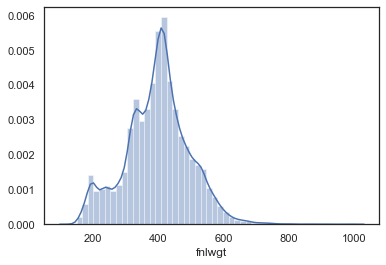


** Antiga Distribuição **


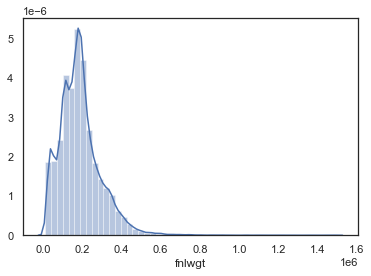

In [153]:
#Veficando nova distribuição
print('** Nova Distribuição **')
sns.distplot(adultdf5['fnlwgt'])
plt.show()
print('\n** Antiga Distribuição **')
sns.distplot(adultdf4['fnlwgt'])
plt.show()

# Convertendo os dados qualitativos em dummies

In [154]:
adultdf5

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,hoursperweek,class,Class_Dic
0,2,State-gov,281.110708,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2,<=50K,0
1,3,Self-emp-not-inc,289.946068,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,<=50K,0
2,2,Private,435.845578,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,2,<=50K,0
3,3,Private,451.946686,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,2,<=50K,0
4,1,Private,528.515905,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,2,<=50K,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48836,1,Private,460.482076,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,2,<=50K,0
48837,2,Private,435.649141,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,2,<=50K,0
48839,2,Private,552.224365,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,3,<=50K,0
48840,2,Private,290.810677,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,2,<=50K,0


In [156]:
#Removendo as variáveis target
adultdf6 = adultdf5.copy()
adultdf6.drop(['Class_Dic','class'],axis=1,inplace=True)
#tranformando qualitativas em dummies
df_dummie = pd.get_dummies(adultdf6).reset_index(drop=True)
df_dummie

,age,fnlwgt,education-num,hoursperweek,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
0,2,281.110708,13,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
1,3,289.946068,13,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1
2,2,435.845578,9,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
3,3,451.946686,7,2,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
4,1,528.515905,13,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46028,1,460.482076,13,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
46029,2,435.649141,13,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0
46030,2,552.224365,13,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1
46031,2,290.810677,13,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1


In [157]:
#Verificando o shape do df que será usado no algoritmo
print('DataFrame sem Dummie: ', adultdf6.shape)
print('DataFrame com Dummie: ', df_dummie.shape)

DataFrame sem Dummie:  (46033, 11)
DataFrame com Dummie:  (46033, 62)


# Aplicando o Algoritmo

In [160]:
#Separando dados de treino e teste
# Seleção de variáveis preditoras 
atributos2 = list(df_dummie.columns)
# Selection the target feature
atrib_prev2 = ['Class_Dic']
# Creating objetcs for ML
X2 = df_dummie[atributos2].values
Y2 = adultdf5[atrib_prev2].values
# Definindo taxa de split
split_test_size = 0.30
#Criando objetos de treino e teste
from sklearn.model_selection import train_test_split
X2_treino, X2_teste, Y2_treino, Y2_teste = train_test_split(X2, Y2, test_size = split_test_size, random_state = 42)

#Printing out the Test and Train frames information
print("\n******************************************************************************")
print("Imprimindo os dados de treino e teste")
print("{0:0.2f}% nos dados de treino".format((len(X2_treino)/len(df_dummie.index)) * 100))
print("{0:0.2f}% nos dados de teste".format((len(X2_teste)/len(df_dummie.index)) * 100))
print("******************************************************************************\n")

results=[]

# Utilizando um classificador Naive Bayes
print("\n******************************************************************************")
print("Utilizando um classificador Naive Bayes")
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from sklearn.metrics import accuracy_score

# Criando o modelo preditivo
modelo_v1 = GaussianNB()
# Treinando o modelo
modelo_v1.fit(X2_treino, Y2_treino.ravel())
# Verificando os dados de treino
modelo_v1_train = modelo_v1.predict(X2_treino)
print("Exatidão TREINO Naive Bayes (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_treino, modelo_v1_train)))
# Verificando nos dados de teste
modelo_v1_test = modelo_v1.predict(X2_teste)
print("\nExatidão TESTE Naive Bayes(Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_teste, modelo_v1_test)))
print("******************************************************************************\n")
results.append(metrics.accuracy_score(Y2_teste, modelo_v1_test).round(2))

# ALGORITMO DE REGRESSAO LOGISTICA
print("\n******************************************************************************")
print("Utilizando um classificador Regressao Logistica")
from sklearn.linear_model import LogisticRegression
# versão do modelo usando Regressão Logística
#C hist - C = 0.7
modelo_v2 = LogisticRegression(C = 1e4, random_state = 42)
modelo_v2.fit(X2_treino, Y2_treino.ravel())
lr_predict_train = modelo_v2.predict(X2_treino)
# Verificando os dados de treino
modelo_v2_train = modelo_v2.predict(X2_treino)
print("Exatidão TREINO Regressao Logistica (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_treino, modelo_v2_train)))
# Verificando nos dados de teste
modelo_v2_test = modelo_v2.predict(X2_teste)
print("\nExatidão TESTE Regressao Logistica (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_teste, modelo_v2_test)))
print("******************************************************************************\n")
results.append(metrics.accuracy_score(Y2_teste, modelo_v2_test).round(3))

# ALGORITMO RANDOM FORREST
print("\n******************************************************************************")
print("Utilizando um classificador Random Forrest")
from sklearn.ensemble import RandomForestClassifier
modelo_v4 = RandomForestClassifier(random_state = 40, n_jobs=10)
modelo_v4.fit(X2_treino, Y2_treino.ravel())
# Verificando os dados de treino
modelo_v4_train = modelo_v4.predict(X2_treino)
print("Exatidão TREINO Random Forrest (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_treino, modelo_v4_train)))
# Verificando nos dados de teste
modelo_v4_test = modelo_v4.predict(X2_teste)
print("\nExatidão TESTE Random Forrest (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_teste, modelo_v4_test)))
print("******************************************************************************\n")
results.append(metrics.accuracy_score(Y2_teste, modelo_v4_test).round(3))

# ALGORITMO RkNN (k-Nearest Neighbors)
print("\n******************************************************************************")
print("Utilizando um classificador kNN (k-Nearest Neighbors)")
from sklearn.neighbors import KNeighborsClassifier
modelo_v5=KNeighborsClassifier(n_neighbors=5)
modelo_v5.fit(X2_treino, Y2_treino.ravel())
# Verificando os dados de treino
modelo_v5_train = modelo_v5.predict(X2_treino)
print("Exatidão TREINO kNN (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_treino, modelo_v5_train)))
# Verificando nos dados de teste
modelo_v5_test = modelo_v5.predict(X2_teste)
print("\nExatidão TESTE kNN (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_teste, modelo_v5_test)))
print("******************************************************************************\n")
results.append(metrics.accuracy_score(Y2_teste, modelo_v5_test).round(3))

# Gradient Boosting Classifier
print("\n******************************************************************************")
print("Utilizando um classificador Gradient Boosting Classifier")
from sklearn.ensemble import GradientBoostingClassifier
gbk = GradientBoostingClassifier()
gbk.fit(X2_treino, Y2_treino)
gbk_pred = gbk.predict(X2_teste)
# Verificando nos dados de teste
acc_gbk = round(accuracy_score(gbk_pred, Y2_teste) * 100, 2)

print("\nExatidão Gradient Boosting Classifier (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_teste, gbk_pred)))
print(acc_gbk)
print("******************************************************************************\n")
results.append(metrics.accuracy_score(Y2_teste, gbk_pred).round(3))

# Stochastic Gradient Descent
print("\n******************************************************************************")
print("Utilizando um classificador Stochastic Gradient Descent")
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier()
sgd.fit(X2_treino, Y2_treino)
SGDC_pred = sgd.predict(X2_teste)
acc_sgd = round(accuracy_score(SGDC_pred, Y2_teste) * 100, 2)
print("\nExatidão Stochastic Gradient Descent (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_teste, SGDC_pred)))
print(acc_sgd)
print("******************************************************************************\n")
results.append(metrics.accuracy_score(Y2_teste, SGDC_pred).round(3))

# Random Forest 2
print("\n******************************************************************************")
print("Utilizando um classificador Random Forest 2")
from sklearn.ensemble import RandomForestClassifier
randomforest = RandomForestClassifier()
randomforest.fit(X2_treino, Y2_treino)
RF2_pred = randomforest.predict(X2_teste)
acc_randomforest = round(accuracy_score(RF2_pred, Y2_teste) * 100, )
print("\nExatidão Random Forest 2 (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_teste, RF2_pred)))
print(acc_randomforest)
print("******************************************************************************\n")
results.append(metrics.accuracy_score(Y2_teste, RF2_pred).round(3))

#Decision Tree
print("\n******************************************************************************")
print("Utilizando um classificador Decision Tree")
from sklearn.tree import DecisionTreeClassifier
decisiontree = DecisionTreeClassifier()
decisiontree.fit(X2_treino, Y2_treino)
DCT_pred = decisiontree.predict(X2_teste)
acc_decisiontree = round(accuracy_score(DCT_pred, Y2_teste) * 100, 2)
print("\nExatidão Decision Tree (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_teste, DCT_pred)))
print(acc_decisiontree)
print("******************************************************************************\n")
results.append(metrics.accuracy_score(Y2_teste, DCT_pred).round(3))

# Linear SVC
print("\n******************************************************************************")
print("Utilizando um classificador Linear SVC")
from sklearn.svm import LinearSVC
linear_svc = LinearSVC()
linear_svc.fit(X2_treino, Y2_treino)
LSVC_pred = linear_svc.predict(X2_teste)
acc_linear_svc = round(accuracy_score(LSVC_pred, Y2_teste) * 100, 2)
print("\nExatidão Linear SVC(Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_teste, LSVC_pred)))
print(acc_linear_svc)
print("******************************************************************************\n")
results.append(metrics.accuracy_score(Y2_teste, LSVC_pred).round(3))

# Support Vector Machines
print("\n******************************************************************************")
print("Utilizando um classificador Support Vector Machines")
from sklearn.svm import SVC

svc = SVC()
svc.fit(X2_treino, Y2_treino)
SVC_pred = svc.predict(X2_teste)
acc_svc = round(accuracy_score(SVC_pred, Y2_teste) * 100, 2)
print("\nExatidão Support Vector Machines (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_teste, SVC_pred)))
print(acc_svc)
print("******************************************************************************\n")
results.append(metrics.accuracy_score(Y2_teste, SVC_pred).round(3))
modelsdf = pd.DataFrame(results,index=['NaiveBayes','RegressãoLogística','RandomForrest_1',\
                                       'k-Nearest Neighbors','Gradient Boosting Classifier',\
                                       'Stochastic Gradient Descent','RandomForrest_2','DecisionTree',\
                                       'LinearSupportVectorMachines','SupportVectorMachines']\
                        , columns=['Exatidao'])




******************************************************************************
Imprimindo os dados de treino e teste
70.00% nos dados de treino
30.00% nos dados de teste
******************************************************************************


******************************************************************************
Utilizando um classificador Naive Bayes
Exatidão TREINO Naive Bayes (Accuracy): 0.7072

Exatidão TESTE Naive Bayes(Accuracy): 0.7090
******************************************************************************


******************************************************************************
Utilizando um classificador Regressao Logistica


/Library/Python/3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Exatidão TREINO Regressao Logistica (Accuracy): 0.8312

Exatidão TESTE Regressao Logistica (Accuracy): 0.8280
******************************************************************************


******************************************************************************
Utilizando um classificador Random Forrest
Exatidão TREINO Random Forrest (Accuracy): 0.9991

Exatidão TESTE Random Forrest (Accuracy): 0.8096
******************************************************************************


******************************************************************************
Utilizando um classificador kNN (k-Nearest Neighbors)
Exatidão TREINO kNN (Accuracy): 0.8621

Exatidão TESTE kNN (Accuracy): 0.7923
******************************************************************************


******************************************************************************
Utilizando um classificador Gradient Boosting Classifier


/Library/Python/3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Exatidão Gradient Boosting Classifier (Accuracy): 0.8356
83.56
******************************************************************************


******************************************************************************
Utilizando um classificador Stochastic Gradient Descent


/Library/Python/3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Exatidão Stochastic Gradient Descent (Accuracy): 0.8201
82.01
******************************************************************************


******************************************************************************
Utilizando um classificador Random Forest 2


/Library/Python/3.7/site-packages/ipykernel_launcher.py:126: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Exatidão Random Forest 2 (Accuracy): 0.8116
81.0
******************************************************************************


******************************************************************************
Utilizando um classificador Decision Tree

Exatidão Decision Tree (Accuracy): 0.7755
77.55
******************************************************************************


******************************************************************************
Utilizando um classificador Linear SVC


/Library/Python/3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Python/3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Python/3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Exatidão Linear SVC(Accuracy): 0.7970
79.7
******************************************************************************


******************************************************************************
Utilizando um classificador Support Vector Machines

Exatidão Support Vector Machines (Accuracy): 0.7531
75.31
******************************************************************************



In [168]:
modelsdf = modelsdf.apply(lambda x:x*100)
modelsdf.sort_values(by = 'Exatidao', ascending=False)

,Exatidao
Gradient Boosting Classifier,83.6
RegressãoLogística,82.8
Stochastic Gradient Descent,82.0
RandomForrest_2,81.2
RandomForrest_1,81.0
LinearSupportVectorMachines,79.7
k-Nearest Neighbors,79.2
DecisionTree,77.5
SupportVectorMachines,75.3
NaiveBayes,71.0


## Outliers

* Vamos verificar se removendo a grande quantidade de outliers o modelo fica mais assertivo

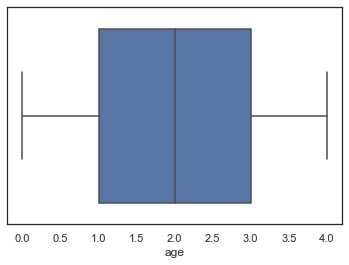

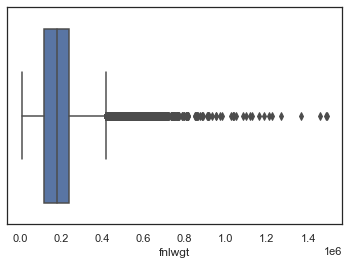

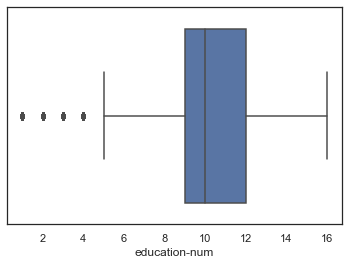

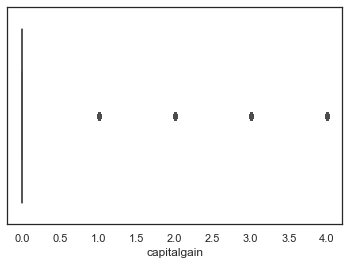

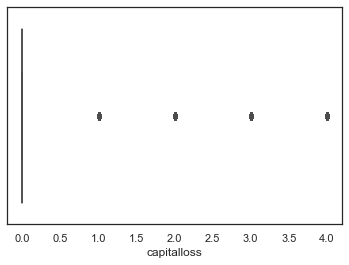

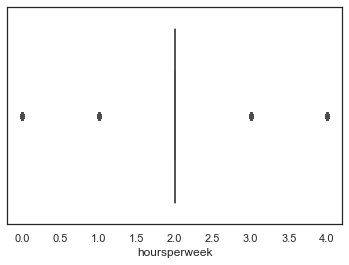

In [170]:
#Verificando graficamente os outliers
#Grafico boxplot
for graf2 in nunfeat:
    sns.boxplot(adultdf[graf2])
    plt.show()

In [187]:
#Removendo outliers do dataset
from scipy.stats import zscore
z_score = zscore(adultdf5[nunfeat2])
abs_zscore = np.abs(z_score)
linhas_out = (abs_zscore>3)
adultdf7 = adultdf5.copy()
adultdf7.drop(adultdf7[linhas_out].index, axis=0, inplace=True)
#Verificando linhas apagadas
print('Shape antes de apagar outliers: ', adultdf5.shape)
print('Shape após de apagar outliers: ', adultdf7.shape)

Shape antes de apagar outliers:  (46033, 13)
Shape apos de apagar outliers:  (45581, 13)


In [191]:
#removendo tagert do dataset
adultdf8 = adultdf7.copy()
adultdf8.drop(['Class_Dic','class'], axis=1, inplace=True)
#tranformando qualitativas em dummies
df_dummie2 = pd.get_dummies(adultdf8).reset_index(drop=True)

In [ ]:
#Removendo as variáveis target
adultdf6 = adultdf5.copy()
adultdf6.drop(['Class_Dic','class'],axis=1,inplace=True)
#tranformando qualitativas em dummies
df_dummie = pd.get_dummies(adultdf6).reset_index(drop=True)
df_dummie

In [192]:
#Verificando o shape do df que será usado no algoritmo
print('DataFrame sem Dummie: ', adultdf7.shape)
print('DataFrame com Dummie: ', df_dummie2.shape)

DataFrame sem Dummie:  (45581, 13)
DataFrame com Dummie:  (45581, 62)


In [201]:
#Separando dados de treino e teste
# Seleção de variáveis preditoras 
atributos2 = list(df_dummie.columns)
# Selection the target feature
atrib_prev2 = ['Class_Dic']
# Creating objetcs for ML
X2 = df_dummie2[atributos2].values
Y2 = adultdf7[atrib_prev2].values
# Definindo taxa de split
split_test_size = 0.30
#Criando objetos de treino e teste
from sklearn.model_selection import train_test_split
X2_treino, X2_teste, Y2_treino, Y2_teste = train_test_split(X2, Y2, test_size = split_test_size, random_state = 42)

#Printing out the Test and Train frames information
print("\n******************************************************************************")
print("Imprimindo os dados de treino e teste")
print("{0:0.2f}% nos dados de treino".format((len(X2_treino)/len(df_dummie2.index)) * 100))
print("{0:0.2f}% nos dados de teste".format((len(X2_teste)/len(df_dummie2.index)) * 100))
print("******************************************************************************\n")

results=[]

# Utilizando um classificador Naive Bayes
print("\n******************************************************************************")
print("Utilizando um classificador Naive Bayes")
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from sklearn.metrics import accuracy_score

# Criando o modelo preditivo
modelo_v1 = GaussianNB()
# Treinando o modelo
modelo_v1.fit(X2_treino, Y2_treino.ravel())
# Verificando os dados de treino
modelo_v1_train = modelo_v1.predict(X2_treino)
print("Exatidão TREINO Naive Bayes (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_treino, modelo_v1_train)))
# Verificando nos dados de teste
modelo_v1_test = modelo_v1.predict(X2_teste)
print("\nExatidão TESTE Naive Bayes(Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_teste, modelo_v1_test)))
print("******************************************************************************\n")
results.append(metrics.accuracy_score(Y2_teste, modelo_v1_test).round(2))

# ALGORITMO DE REGRESSAO LOGISTICA
print("\n******************************************************************************")
print("Utilizando um classificador Regressao Logistica")
from sklearn.linear_model import LogisticRegression
# versão do modelo usando Regressão Logística
#C hist - C = 0.7
modelo_v2 = LogisticRegression(C = 1e4, random_state = 42)
modelo_v2.fit(X2_treino, Y2_treino.ravel())
lr_predict_train = modelo_v2.predict(X2_treino)
# Verificando os dados de treino
modelo_v2_train = modelo_v2.predict(X2_treino)
print("Exatidão TREINO Regressao Logistica (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_treino, modelo_v2_train)))
# Verificando nos dados de teste
modelo_v2_test = modelo_v2.predict(X2_teste)
print("\nExatidão TESTE Regressao Logistica (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_teste, modelo_v2_test)))
print("******************************************************************************\n")
results.append(metrics.accuracy_score(Y2_teste, modelo_v2_test).round(3))

# ALGORITMO RANDOM FORREST
print("\n******************************************************************************")
print("Utilizando um classificador Random Forrest")
from sklearn.ensemble import RandomForestClassifier
modelo_v4 = RandomForestClassifier(random_state = 40, n_jobs=10)
modelo_v4.fit(X2_treino, Y2_treino.ravel())
# Verificando os dados de treino
modelo_v4_train = modelo_v4.predict(X2_treino)
print("Exatidão TREINO Random Forrest (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_treino, modelo_v4_train)))
# Verificando nos dados de teste
modelo_v4_test = modelo_v4.predict(X2_teste)
print("\nExatidão TESTE Random Forrest (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_teste, modelo_v4_test)))
print("******************************************************************************\n")
results.append(metrics.accuracy_score(Y2_teste, modelo_v4_test).round(3))

# ALGORITMO RkNN (k-Nearest Neighbors)
print("\n******************************************************************************")
print("Utilizando um classificador kNN (k-Nearest Neighbors)")
from sklearn.neighbors import KNeighborsClassifier
modelo_v5=KNeighborsClassifier(n_neighbors=5)
modelo_v5.fit(X2_treino, Y2_treino.ravel())
# Verificando os dados de treino
modelo_v5_train = modelo_v5.predict(X2_treino)
print("Exatidão TREINO kNN (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_treino, modelo_v5_train)))
# Verificando nos dados de teste
modelo_v5_test = modelo_v5.predict(X2_teste)
print("\nExatidão TESTE kNN (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_teste, modelo_v5_test)))
print("******************************************************************************\n")
results.append(metrics.accuracy_score(Y2_teste, modelo_v5_test).round(3))

# Gradient Boosting Classifier
print("\n******************************************************************************")
print("Utilizando um classificador Gradient Boosting Classifier")
from sklearn.ensemble import GradientBoostingClassifier
gbk = GradientBoostingClassifier()
gbk.fit(X2_treino, Y2_treino)
gbk_pred = gbk.predict(X2_teste)
# Verificando nos dados de teste
acc_gbk = round(accuracy_score(gbk_pred, Y2_teste) * 100, 2)

print("\nExatidão Gradient Boosting Classifier (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_teste, gbk_pred)))
print(acc_gbk)
print("******************************************************************************\n")
results.append(metrics.accuracy_score(Y2_teste, gbk_pred).round(3))

# Stochastic Gradient Descent
print("\n******************************************************************************")
print("Utilizando um classificador Stochastic Gradient Descent")
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier()
sgd.fit(X2_treino, Y2_treino)
SGDC_pred = sgd.predict(X2_teste)
acc_sgd = round(accuracy_score(SGDC_pred, Y2_teste) * 100, 2)
print("\nExatidão Stochastic Gradient Descent (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_teste, SGDC_pred)))
print(acc_sgd)
print("******************************************************************************\n")
results.append(metrics.accuracy_score(Y2_teste, SGDC_pred).round(3))

# Random Forest 2
print("\n******************************************************************************")
print("Utilizando um classificador Random Forest 2")
from sklearn.ensemble import RandomForestClassifier
randomforest = RandomForestClassifier()
randomforest.fit(X2_treino, Y2_treino)
RF2_pred = randomforest.predict(X2_teste)
acc_randomforest = round(accuracy_score(RF2_pred, Y2_teste) * 100, )
print("\nExatidão Random Forest 2 (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_teste, RF2_pred)))
print(acc_randomforest)
print("******************************************************************************\n")
results.append(metrics.accuracy_score(Y2_teste, RF2_pred).round(3))

#Decision Tree
print("\n******************************************************************************")
print("Utilizando um classificador Decision Tree")
from sklearn.tree import DecisionTreeClassifier
decisiontree = DecisionTreeClassifier()
decisiontree.fit(X2_treino, Y2_treino)
DCT_pred = decisiontree.predict(X2_teste)
acc_decisiontree = round(accuracy_score(DCT_pred, Y2_teste) * 100, 2)
print("\nExatidão Decision Tree (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_teste, DCT_pred)))
print(acc_decisiontree)
print("******************************************************************************\n")
results.append(metrics.accuracy_score(Y2_teste, DCT_pred).round(3))

# Linear SVC
print("\n******************************************************************************")
print("Utilizando um classificador Linear SVC")
from sklearn.svm import LinearSVC
linear_svc = LinearSVC()
linear_svc.fit(X2_treino, Y2_treino)
LSVC_pred = linear_svc.predict(X2_teste)
acc_linear_svc = round(accuracy_score(LSVC_pred, Y2_teste) * 100, 2)
print("\nExatidão Linear SVC(Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_teste, LSVC_pred)))
print(acc_linear_svc)
print("******************************************************************************\n")
results.append(metrics.accuracy_score(Y2_teste, LSVC_pred).round(3))

# Support Vector Machines
print("\n******************************************************************************")
print("Utilizando um classificador Support Vector Machines")
from sklearn.svm import SVC

svc = SVC()
svc.fit(X2_treino, Y2_treino)
SVC_pred = svc.predict(X2_teste)
acc_svc = round(accuracy_score(SVC_pred, Y2_teste) * 100, 2)
print("\nExatidão Support Vector Machines (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_teste, SVC_pred)))
print(acc_svc)
print("******************************************************************************\n")
results.append(metrics.accuracy_score(Y2_teste, SVC_pred).round(3))
modelsdf2 = pd.DataFrame(results,index=['NaiveBayes2','RegressãoLogística2','RandomForrest_1_2',\
                                       'k-Nearest Neighbors2','Gradient Boosting Classifier2',\
                                       'Stochastic Gradient Descent2','RandomForrest_2_2','DecisionTree2',\
                                       'LinearSupportVectorMachines2','SupportVectorMachines2']\
                        , columns=['Exatidao'])





******************************************************************************
Imprimindo os dados de treino e teste
70.00% nos dados de treino
30.00% nos dados de teste
******************************************************************************


******************************************************************************
Utilizando um classificador Naive Bayes
Exatidão TREINO Naive Bayes (Accuracy): 0.7386

Exatidão TESTE Naive Bayes(Accuracy): 0.7307
******************************************************************************


******************************************************************************
Utilizando um classificador Regressao Logistica


/Library/Python/3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Exatidão TREINO Regressao Logistica (Accuracy): 0.8239

Exatidão TESTE Regressao Logistica (Accuracy): 0.8226
******************************************************************************


******************************************************************************
Utilizando um classificador Random Forrest
Exatidão TREINO Random Forrest (Accuracy): 0.9990

Exatidão TESTE Random Forrest (Accuracy): 0.8040
******************************************************************************


******************************************************************************
Utilizando um classificador kNN (k-Nearest Neighbors)
Exatidão TREINO kNN (Accuracy): 0.8614

Exatidão TESTE kNN (Accuracy): 0.7898
******************************************************************************


******************************************************************************
Utilizando um classificador Gradient Boosting Classifier


/Library/Python/3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Exatidão Gradient Boosting Classifier (Accuracy): 0.8347
83.47
******************************************************************************


******************************************************************************
Utilizando um classificador Stochastic Gradient Descent


/Library/Python/3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Exatidão Stochastic Gradient Descent (Accuracy): 0.7321
73.21
******************************************************************************


******************************************************************************
Utilizando um classificador Random Forest 2


/Library/Python/3.7/site-packages/ipykernel_launcher.py:126: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Exatidão Random Forest 2 (Accuracy): 0.8020
80.0
******************************************************************************


******************************************************************************
Utilizando um classificador Decision Tree

Exatidão Decision Tree (Accuracy): 0.7642
76.42
******************************************************************************


******************************************************************************
Utilizando um classificador Linear SVC


/Library/Python/3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Python/3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Python/3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Exatidão Linear SVC(Accuracy): 0.7682
76.82
******************************************************************************


******************************************************************************
Utilizando um classificador Support Vector Machines

Exatidão Support Vector Machines (Accuracy): 0.7467
74.67
******************************************************************************



In [202]:
modelsdf2 = modelsdf2.apply(lambda x:x*100)
modelsdf2.sort_values(by = 'Exatidao', ascending=False)

,Exatidao
Gradient Boosting Classifier2,83.5
RegressãoLogística2,82.3
RandomForrest_1_2,80.4
RandomForrest_2_2,80.2
k-Nearest Neighbors2,79.0
LinearSupportVectorMachines2,76.8
DecisionTree2,76.4
SupportVectorMachines2,74.7
Stochastic Gradient Descent2,73.2
NaiveBayes2,73.0


In [206]:
#Apresentando resultados das duas rodadas de algoritmos de forma unificada
models_all = pd.concat([modelsdf,modelsdf2],axis=0)
models_all.sort_values(by='Exatidao', ascending=False)

,Exatidao
Gradient Boosting Classifier,83.6
Gradient Boosting Classifier2,83.5
RegressãoLogística,82.8
RegressãoLogística2,82.3
Stochastic Gradient Descent,82.0
RandomForrest_2,81.2
RandomForrest_1,81.0
RandomForrest_1_2,80.4
RandomForrest_2_2,80.2
LinearSupportVectorMachines,79.7


* A remoção dos outiliers representou melhora em alguns altoritmos, contudo o melhor resultado foi atingido pelo Gradient Boosting Calssifier trabalhando com outliers.

## Analisando o resultado do algoritmo

* Para termos uma melhor profundidade na análise dos resultados so algoritmo vamos criar a matriz de confusão

In [225]:
print("************************************************************************************")
print("Matriz de Confusão\n")
dado = metrics.confusion_matrix(Y2_teste, gbk_pred)
dfco = pd.DataFrame(dado)
print(dfco)
print("************************************************************************************")

print("************************************************************************************")
print("                   Relatório de Classificação\n")
print(metrics.classification_report(Y2_teste, gbk_pred))
print("************************************************************************************")

************************************************************************************
Matriz de Confusão

      0     1
0  9432   779
1  1481  1983
************************************************************************************
************************************************************************************
                   Relatório de Classificação

              precision    recall  f1-score   support

           0       0.86      0.92      0.89     10211
           1       0.72      0.57      0.64      3464

    accuracy                           0.83     13675
   macro avg       0.79      0.75      0.77     13675
weighted avg       0.83      0.83      0.83     13675

************************************************************************************
